# Convolutional Neural Network 

**Notebook Content**
1. [MLP for MNIST](#s1)
2. Creating a Filter for Edges
3.
4.


White close to 255, Dark close to 0. <br>

This MNIST data has gone through a pre-processing. They are rescaled such that pixel value is from 0 to 1

To Normalize => x /255

Normaly we want a Normalization step because Neural Networks rely on Gradient Calculations. Normalizing the pixel values help keep these gradient calculations stay consistent and not get so large that they slow down or prevent a network from training

**Normalizing Image Inputs**
x-mean / std

Sometimes we use approximation by using mean & std of 0.5

For image inputs we need the pixel numbers to be positive so we often choose to scale the data in a normalized range of [0,1]


<a id = 's1' ></a>
## Multi Layer Perceptron for MNIST
---

Process
> 1. Load & Visualize the data
> 2. Define Neural Network
> 3. Train the model
> 4. Evaluate the performance of model on test dataset

### Load Libraries

In [2]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

### Load the data  - Training, Validation & Test Dataset 

In [11]:
# Load the data  -- Create Training, Validation & Test Datasets

transform = transforms.ToTensor()

train_data = datasets.MNIST ( 'MNIST_data', train = True, transform = transform, download = True)

test_data = datasets.MNIST ('MNIST_data', train = False, transform = transform, download = True)

# we need a split point to separate between training dataset and validation dataset. 
# Simply we can just keep first 80% for Training and last 20% for Validation
train_size, valid_size = 0.8,0.2
len_dataset = len(train_data)
split = int(len_dataset*train_size)
train_idx, valid_idx = range(0,split), range(split,len(train_data))
train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)

# Now what we can also do is ... shuffle the indices to create random training and validation dataset
train_size, valid_size = 0.8, 0.2
len_dataset = len(train_data)
split = int(len_dataset*train_size)
indices = list(range(len_dataset)) # we need indices object as a list 
np.random.shuffle(indices) # now here i have shuffled the indices
train_idx, test_idx = indices[:split], indices[split:]
train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)


# prepare dataloaders
train_loader = DataLoader(train_data, batch_size = 20, sampler = train_sampler ) # a new sampler argument will be used
valid_loader = DataLoader(train_data, batch_size = 20, sampler = valid_sampler ) # a new sampler argument will be used
test_loader = DataLoader(test_data, batch_size = 20)

###  Visualize the data

In [4]:
# Visualize the data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 

In [8]:
print (images)
print (labels)

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. 

In [7]:
print (images[0].shape)
print (np.squeeze(images[0]).shape)

(1, 28, 28)
(28, 28)


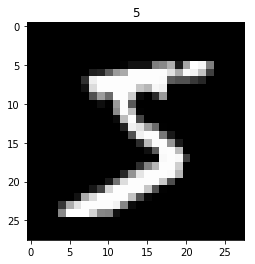

In [10]:
# look at one image first  
plt.imshow(np.squeeze(images[0]), cmap = 'gray')
plt.title(str(labels[0].item()))
plt.show()

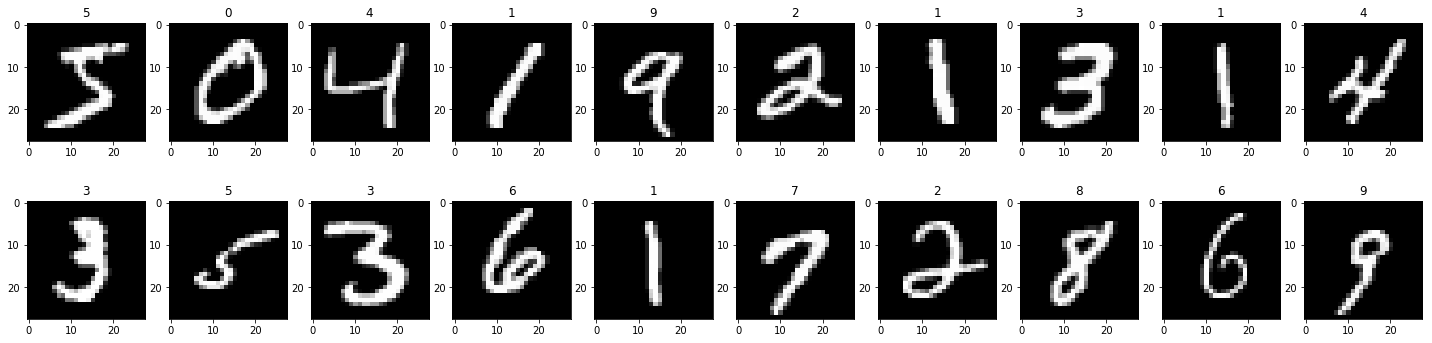

In [29]:
# Now let's see all the images in the batch at once
fig = plt.figure (figsize  = (25, 6) )
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1)
    img = np.squeeze(images[idx])
    lbl = str( labels[idx].item() )
    ax.imshow(img, cmap = 'gray')
    ax.set_title( lbl)

**View an image in more details**

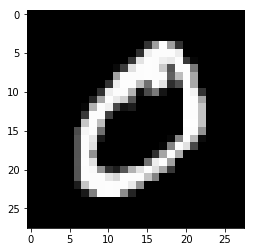

In [30]:
img = np.squeeze(images[1])
lbl = str( labels[1].item() )

plt.imshow(img, cmap = 'gray')

### Define the Network Architecture

In [16]:
# Define the NN Architecture

class Model (nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64,10)
        
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(-1, 784)
        h1 = self.dropout( F.relu( self.fc1(x) ) )
        h2 = self.dropout( F.relu( self.fc2(h1) ) )
        out = self.fc3(h2)
        return out
    
# Instantate the model
model = Model()
print (model)

Model(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


### Specify the Loss function and Optimizer 

In [17]:
loss_fn = nn.CrossEntropyLoss()
# Refer to the documentation here to see what CrossEntropyLoss function is doing. 
# It first computes the SoftMax function on an output layer and then doing Negative Log Loss

optimizer = optim.SGD(model.parameters(), lr = 0.001)

### Train the Network (calculate Training loss, Validation loss and Test loss)

In [18]:
# Run the training loop

epochs = 15
valid_loss_min = np.Inf
train_losses, valid_losses = [], []
for e in range(epochs):
    train_loss, valid_loss = 0.0, 0.0
    
    model.train() # set model in training mode
    for x , y in train_loader:
        optimizer.zero_grad()
        y_score = model.forward(x)
        loss = loss_fn(y_score, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        
    ## Model Validation
    model.eval() # set model in evaluation mode
    for xv, yv in valid_loader:
        yv_score = model.forward(xv)
        loss_v = loss_fn(yv_score, yv)
        
        valid_loss += loss_v.item()
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print ('\nEpoch {}/{}'.format(e+1, epochs), 'Training loss: ', train_loss, 'Validation loss:', valid_loss)
    
    if valid_loss < valid_loss_min:
        print ('Validation loss decreased from {} to {}'.format(valid_loss_min, valid_loss))
        valid_loss_min = valid_loss
        # save the model
        torch.save(model.state_dict(), 'model.pt')
        print ('Saving Model')
    



Epoch 1/15 Training loss:  5438.900950431824 Validation loss: 1325.2616093158722
Validation loss decreased from inf to 1325.2616093158722
Saving Model

Epoch 2/15 Training loss:  5020.241348385811 Validation loss: 1132.4338146448135
Validation loss decreased from 1325.2616093158722 to 1132.4338146448135
Saving Model

Epoch 3/15 Training loss:  3850.9250228405 Validation loss: 729.1676871180534
Validation loss decreased from 1132.4338146448135 to 729.1676871180534
Saving Model

Epoch 4/15 Training loss:  2599.8952816724777 Validation loss: 483.3228820860386
Validation loss decreased from 729.1676871180534 to 483.3228820860386
Saving Model

Epoch 5/15 Training loss:  1993.5392388403416 Validation loss: 377.19142439961433
Validation loss decreased from 483.3228820860386 to 377.19142439961433
Saving Model

Epoch 6/15 Training loss:  1685.6903761327267 Validation loss: 319.9692426174879
Validation loss decreased from 377.19142439961433 to 319.9692426174879
Saving Model

Epoch 7/15 Training

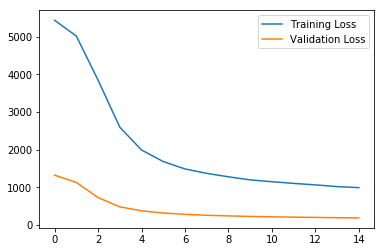

In [19]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(valid_losses, label = 'Validation Loss')
plt.legend()
plt.show()

### Test the Trained Network

In [23]:
test_loss = 0.0
for xt, yt in test_loader:
    yt_score = model.forward(xt)
    loss = loss_fn(yt_score, yt)
#     batch_size = x_test.size(0)
#     avg_batch_loss = loss.item()
#     batch_loss = avg_batch_loss * batch_size
    test_loss = test_loss + loss.item()

print ('Test Loss: ', test_loss)

Test Loss:  162.67079252377152
